# Setup

In [0]:
%%capture
%pip install poetry
%pip install git+https://github.com/oughtinc/ergo.git@munging-to-files
%pip install xlrd

In [0]:
%load_ext google.colab.data_table

In [0]:
%%capture
import ergo
import numpy as np
import pandas as pd
import ssl
import math
import datetime
import warnings
import functools
import sklearn

from datetime import timedelta, date

In [0]:
warnings.filterwarnings(module="plotnine", action="ignore")
warnings.filterwarnings(module="jax", action="ignore")
ssl._create_default_https_context = ssl._create_unverified_context

## Import modules with data and models

In [5]:
!git clone -b munging-to-files https://github.com/oughtinc/ergo

Cloning into 'ergo'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 2324 (delta 35), reused 40 (delta 20), pack-reused 2259
Receiving objects: 100% (2324/2324), 9.62 MiB | 25.80 MiB/s, done.
Resolving deltas: 100% (1548/1548), done.


In [0]:
import sys

sys.path.append('ergo/notebooks/el-paso/scripts')

In [0]:
import texas_data
import onlyasith
import krismoore
import brachbach

# Load questions

We'll load all questions from the [El Paso](https://pandemic.metaculus.com/questions/4161/el-paso-series-supporting-covid-19-response-planning-in-a-mid-sized-city/) series.

In [8]:
metaculus = ergo.Metaculus(
    username="oughtpublic", 
    password="123456",
    api_domain = "pandemic"
)

questions = metaculus.get_questions(cat="internal--el-paso")

# the most logical order for the questions
order = [4128, 4137, 4152, 4170, 4155, 4154, 4153, 4204, 4201, 4185]

questions.sort(key = lambda q: order.index(q.id))

ergo.MetaculusQuestion.to_dataframe(questions)

,id,title,resolve_time
0,4128,"When will El Paso County, Texas, experience it...",2020-12-31T23:01:00Z
1,4137,How many new infections will be reported in El...,2020-12-31T23:00:00Z
2,4152,What will the average number of reported daily...,2020-12-31T23:00:00Z
3,4170,What will the average number of reported daily...,2020-12-31T23:00:00Z
4,4155,What portion of in-hospital cases in El Paso C...,2020-12-31T23:00:00Z
5,4154,What portion of in-hospital patients with Covi...,2020-12-31T23:00:00Z
6,4153,What will the maximum number of in-hospital la...,2021-01-01T00:00:00Z
7,4204,How many patients with Covid-19 in El Paso Cou...,2020-12-31T23:00:00Z
8,4201,How many patients with Covid-19 in El Paso Cou...,2020-12-31T23:00:00Z
9,4185,What will the unemployment rate be in El Paso ...,2020-12-31T23:00:00Z


# Ergo extensions

We'll define some helper functions that might get moved into Ergo in the future.

In [0]:
START_DATE = date(2020, 4, 1)


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


# Memoization

memoized_functions = []

def mem(func):
    func = functools.lru_cache(None)(func)
    memoized_functions.append(func)
    return func

def clear_mem():
    for func in memoized_functions:
        func.cache_clear()


# Associating functions with Metaculus questions

question_samplers = {}
question_function_names = {}
id_to_question = dict((q.id, q) for q in questions)

def question(question_id, community_weight=0):
    q = id_to_question[question_id]
    q.refresh_question()
    def decorator(func):
        @functools.wraps(func)
        @mem
        def sampler():
            if ergo.flip(community_weight):
                value = q.sample_community()
            else:
                value = func()
            tagged_value = value
            if isinstance(value, date):
                # FIXME: Ergo needs to handle dates
                tagged_value = int((value - START_DATE).days)
            ergo.tag(tagged_value, str(question_id))
            return value
        question_samplers[question_id] = sampler
        question_function_names[question_id] = func.__name__
        sampler.question_id = question_id
        return sampler
    return decorator

def summarize_question_samples(samples):
    summary = samples.describe().transpose().round(2)
    summary.index = [question_function_names[int(i)] for i in summary.index]
    display(summary)

# Plotting distributions on return values
def plot_question(question_fn, num_samples=200):
  def model():
      clear_mem()
      question_fn()

  samples = ergo.run(model, num_samples=num_samples)

  summarize_question_samples(samples)
  question_id = question_fn.question_id

  q = id_to_question[question_id]
  key = str(q.id)
  q_samples = samples[str(q.id)]

  if key == "4128": # Date question: Need to convert back to date from days (https://github.com/oughtinc/ergo/issues/144)
      q_samples = np.array([START_DATE + timedelta(s) for s in q_samples])

  q.refresh_question() 
  print(q.show_prediction(samples=q_samples, show_community=True, percent_kept=0.9))

# External data (cases, estimates, models)

## Texas government cases data

In [13]:
el_paso_cases = texas_data.get_el_paso_data()

el_paso_cases

,Cases so far,New cases
2020-03-04,0,NaN
2020-03-05,0,0
2020-03-06,0,0
2020-03-09,0,0
2020-03-10,0,0
2020-03-11,0,0
2020-03-12,0,0
2020-03-13,0,0
2020-03-15,1,1
2020-03-16,1,0


## @onlyasith's cases model



Pulled [here](https://docs.google.com/spreadsheets/d/1L6pzFAEJ6MfnUwt-ea6tetKyvdi0YubnK_70SGm436c/edit#gid=1807978187)

In [14]:
projected_cases = onlyasith.get_onlyasith_results()

projected_cases

,Cases so far,New cases
Date,,
2020-04-04,96,NaN
2020-04-05,106,10.0
2020-04-06,115,9.0
2020-04-07,125,10.0
2020-04-08,153,28.0
...,...,...
2020-09-30,1090,0.0
2020-10-01,1090,0.0
2020-10-02,1091,1.0


## @KrisMoore's compiled data

Pulled [here](https://docs.google.com/spreadsheets/d/1eGF9xYmDmvAkr-dCmd-N4efHzPyYEfVl0YmL9zBvH9Q/edit#gid=1694267458).

In [15]:
compiled_data = krismoore.get_krismoore_data()

compiled_data

,cases,new_cases,2_day_sma_new_cases,presumed_active_cases,fatalities,recovered,In hospital confirmed,in_icu,on_ventilator,tests_el_paso_dpt_public_health_only,new_tests_el_paso_dpt_public_health_only,tests_el_paso_inc_other_labs,tests_texas_all_sources,population
date,,,,,,,,,,,,,,
2020-03-04,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"952,366"
2020-03-05,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## @brachbach model (cases -> hospitalized)

In [0]:
get_daily_hospital_confirmed = brachbach.get_daily_hospital_confirmed

# Model components

In [0]:
@mem
def daily_infections(date: date) -> int:
    """
    What is the number of reported (new) Covid-19 infections on [date]?
    """
    try:
        # Look up Texas Government data
        new_cases = el_paso_cases.loc[date, "New cases"]
        if np.isnan(new_cases):
            raise KeyError
        return new_cases
    except KeyError:
        try:
            # Look up projections from @onlyasith's model
            cases = projected_cases.loc[date, "New cases"]
            if np.isnan(cases):
                raise KeyError
            
            # Add some (fairly arbitrary) uncertainty around this point estimate
            if cases == 0:
              return cases
            cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
            return np.clip(cases_estimate, cases * 0.5, cases * 2)
        except KeyError:
            # We're beyond the time range for data and model
            return 0

@mem
def mean_infections(start_date: date, end_date: date):
    """
    What is the average number of reported new infections for this range of 
    dates? (Including start date, excluding end date)
    """
    days = daterange(start_date, end_date)
    return np.mean([daily_infections(day) for day in days])

# Build @brachbach regression model
hospital_confirmed_from_daily_infected_model = get_daily_hospital_confirmed(compiled_data, daily_infections)

@mem
def hospital_confirmed_for_date(date: date) -> int:
    """
    The total number of lab-confirmed COVID-19 patients in El Paso County in
    the hospital on this date
    """
    try:
        # Look up in-hospital confirmed cases from @KrisMoore's compiled data
        new_hospital_confirmed = compiled_data.loc[date, "In hospital confirmed"]
        if np.isnan(new_hospital_confirmed):
            raise KeyError
        return new_hospital_confirmed
    except KeyError:
        try:
            # Get point estimate from @brachbach's regression model
            cases = hospital_confirmed_from_daily_infected_model(date)
            
            # Add some (fairly arbitrary) uncertainty around this point estimate
            if cases == 0:
              return cases
            cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
            return np.clip(cases_estimate, cases * 0.5, cases * 2)
        except KeyError:
            return 0

@mem
def frac_icu_ventilation():
    """
    Proportion of ICU admissions requiring ventilation

    Approach (PabloStafforini et al): 
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO: 
    - Improve how we use case data
    - Add qualitative adjustments
    """
    ventilation_pseudocounts = 25 + 17 + 0.05 * 1150 + 0.1 * 132
    icu_pseudocounts = 100 + 36 + 0.05 * 1300 + 0.1 * 196
    return ergo.beta_from_hits(ventilation_pseudocounts, icu_pseudocounts)

# El Paso questions

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,200.0,25.06,9.98,14.0,23.75,25.0,25.0,138.0


None


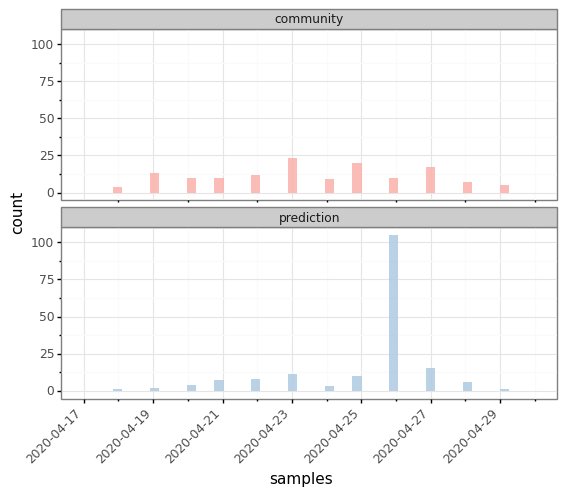

In [18]:
@question(4128, community_weight=0.5)
def peak_infection_date() -> date:
    """
    When will El Paso County, Texas, experience its first peak number of COVID
    infections?
    """    
    end_date = date(2020, 7, 1)
    for today in daterange(START_DATE, end_date):
        yesterday = today - timedelta(1)
        tomorrow = today + timedelta(1)
        two_day_mean = mean_infections(yesterday, tomorrow)
        future_means = [mean_infections(today + timedelta(i), today + timedelta(i+2)) for i in range(10)]
        if two_day_mean > max(future_means):
            return today
    return end_date
plot_question(peak_infection_date)

In [19]:
@question(4137, community_weight=0.5)
def peak_infections():
    """
    How many new infections will be reported in El Paso on the day on which
    the number of new reported infections peaks?
    """
    peak = peak_infection_date()
    return daily_infections(peak)
plot_question(peak_infections)

ValueError: ignored

In [0]:
@question(4152, community_weight=0.5)
def mean_infections_peak345():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 3rd, 4th and 5th days after the first "peak"?
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(3), peak + timedelta(6))
plot_question(mean_infections_peak345)

In [0]:

@question(4170, community_weight=0.8)
def mean_infections_peak678():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 6th, 7th and 8th days after the first "peak"?  
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(6), peak + timedelta(9))
plot_question(mean_infections_peak678)

In [0]:
@question(4155, community_weight=0.7)
def frac_patients_icu():
    """
    What portion of in-hospital cases in El Paso County will require admission
    to the ICU?

    Following @katifish's approach:
    https://pandemic.metaculus.com/questions/4155/#comment-28054

    TODO: Add others from katifish comment
    """
    alpha = 0.1 # Rescaling counts becase we're more uncertain than implied by counts
    return ergo.random_choice([
      ergo.beta_from_hits(alpha * 121, alpha * 508),
      ergo.beta_from_hits(alpha * 181, alpha * 507),
    ])
plot_question(frac_patients_icu)

In [0]:
@question(4154, community_weight=0.3)
def frac_patients_invasive():
    """
    What portion of in-hospital patients with Covid-19 in El Paso County will
    require invasive ventilation?

    Following @PabloStafforini's indirect estimation approach:
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO:
    - Combine with direct estimate
      direct_estimate = ergo.beta_from_hits(0.1 * 130, 0.1 * 393)
    """
    return frac_patients_icu() * frac_icu_ventilation()
plot_question(frac_patients_invasive)

In [0]:
@question(4153, community_weight=0.3)
def max_30d_hospital_confirmed_for_peak():
    """
    What will the maximum number of in-hospital lab-confirmed COVID-19 
    patients in El Paso County, in the 30-day period during which the "peak"
    occurs?
    """
    peak = peak_infection_date()
    days = daterange(peak - timedelta(15), peak + timedelta(15))
    return max(hospital_confirmed_for_date(day) for day in days)

plot_question(max_30d_hospital_confirmed_for_peak)

In [0]:
@question(4204)
def peak_icu_admissions():
    """
    How many patients with Covid-19 in El Paso County will be admitted to the
    ICU on the day when the number of hospital admissions of cases peak?

    Following @Tamay's approach:
    https://pandemic.metaculus.com/questions/4204/

    Alternative:    
    - peak = peak_hospitalizations_date()
    - return daily_icu_admissions(peak)

    FIXME: Admissions vs in-hospital patients unclear

    Not mixing in community since this is just the product of two other questions.    
    """
    max_patients = max_30d_hospital_confirmed_for_peak()
    return max_patients * frac_patients_icu()
plot_question(max_30d_hospital_confirmed_for_peak)

In [0]:
@question(4201)
def peak_invasive_ventilation():
    """
    How many patients with Covid-19 in El Paso County will require invasive 
    ventilation on the day when the number of hospital admissions of cases 
    peak?

    Following @Tamay's approach:
    https://pandemic.metaculus.com/questions/4201/#comment-28004

    Not mixing in community since this is just the product of two other questions.
    """
    return frac_icu_ventilation() * peak_icu_admissions()

plot_question(peak_invasive_ventilation)

# Generate predictions for all questions

In [0]:
def model():
    clear_mem()
    for question_sampler in question_samplers.values():
        question_sampler()

samples = ergo.run(model, num_samples=2000)

summarize_question_samples(samples)

# Compare predictions to community

This takes a while since we're fitting a mixture of logistic distributions to our samples before visualizing (and submitting) them.
These may look a little different from the plots below the questions above, because we've taken more samples from the distribution and we're fitting logistic distributions so we can submit them to metaculus

In [0]:
submissions = {}
for q in questions:
    print(q.id)
    if q.id == 4185: # We didn't predict the unemployment question
        continue

    key = str(q.id)
    q_samples = samples[str(q.id)]

    if key == "4128": # Date question: Need to convert back to date from days (https://github.com/oughtinc/ergo/issues/144)
        q_samples = np.array([START_DATE + timedelta(s) for s in q_samples])
    
    q.refresh_question()

    if q.id in [4201, 4204, 4137, 4152, 4170, 4153]:
      # Clip extreme values for questions that we had issues fitting
      (sample_min, sample_max) = np.quantile(q_samples, [0.02, 0.98])
      q_samples = q_samples[(q_samples >= sample_min) & (q_samples <= sample_max)]

    submission = q.get_submission_from_samples(q_samples)
    submissions[q] = submission
    print(q.show_prediction(samples=submission, show_community=True, percent_kept=0.9))

In [0]:
# Should we submit this to Metaculus? If so, uncomment the following line:
# for q, submission in submissions.items():  
#     q.submit(submission)